<div align="center">
<font color=0F5298 size=5>
Token-level Toxicity Classifier Using Transformers
</font> <br>

<font color=2565AE size=2>
 Natural Language Processing Course - Task 4
</font> <br>

<font color=2565AE size=3>
 Sharif University of Technology - Fall 2023
</font> <br>
<font color=3C99D size=4>
 Contributers: Sina Namazi - Erfan Sadrayieh - Benyamin Maleki
</font> <br>

<font color=3C99D size=4>
STU-Ids (in order): 400110154- 99101835 - 99102286
</font>
</div>


**Firtst, we need to install the necessary libraries.**

In [1]:
# Install neccessary libraries
!pip install transformers
!pip install accelerate -U
!pip install gdown
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.0 MB/s eta 0:00:00


**In the next cell we are going to import the necessary libraries.**

In [2]:
# Import necessary libraries
# Tools
from huggingface_hub import notebook_login
import gdown
from tqdm import tqdm

# Base
import pandas as pd
import numpy as np
from ast import literal_eval

# Torch
import torch

# sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Hugging Face
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import Trainer

# Visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**To push our model to Hugging Face at the end of the notebook, we should login to our the Hugging Face account.**

In [3]:
# Logging into Hugging Face account
notebook_login()

**The device that is going to be used throughout the notebook is chosen in the next cell.**

In [5]:
# Setting up the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

**The dataser used in this notebook is going to be downloaded and loaded as a pandas dataframe in the next two cells.**

In [4]:
# Downloading the dataset
gdown.download(url=f"https://drive.google.com/uc?id=1fs7gIKvNl_GlX9vFUdtMRFWWYeqI3muQ", output='toxic_spans.csv')

Downloading...
From: https://drive.google.com/uc?id=1fs7gIKvNl_GlX9vFUdtMRFWWYeqI3muQ
To: /content/toxic_spans.csv
100%|██████████| 10.6M/10.6M [00:00<00:00, 53.3MB/s]


'toxic_spans.csv'

In [6]:
# Loading the dataset
df = pd.read_csv('toxic_spans.csv')
df = df[['probability', 'type', 'text_of_post']]
df['probability'] = df['probability'].apply(literal_eval)
df['type'] = df['type'].apply(literal_eval)

**Functions used in this notebook are going to be defined in the next cell.**

**These functions include:**

- ```merge_overlapping_ranges()```: This functions is used for extracting data from the csv file and handling ranges of characters for preprocessing purposes.

- ```tokenize_and_align_labels()```: This functions is used for labeling the input tokens to the model, it labels only the first token of each word, so in this way we can give label to each word. The next tokens of each word are given -100 as label which is going to be ignored by nn.CrossEntropyLoss.

- ```compute_metrics()```: This functions computes the metrics needed during training, including precission, recall, F1 ,and accuracy, and is passed to our trainer.

- ```print_metrics()```: This functions is used at the end for evaluating our model and reporting different metrics on different splits of our data.

- ```plot_confusion_matrix()```: This functions is used at the end for evaluating our model on different splits of our data and making the confusion matrix.


In [7]:
# Functions needed for this project:

# merge_overlapping_ranges is used for extracting data from
# the csv file and handling ranges of characters for preprocessing the data
def merge_overlapping_ranges(tuples):
    sorted_tuples = sorted(tuples, key=lambda x: x[0])

    merged_ranges = []
    current_range = sorted_tuples[0]

    for start, end in sorted_tuples[1:]:
        if start <= current_range[1]:
            current_range = (current_range[0], end)
        else:
            merged_ranges.append(current_range)
            current_range = (start, end)

    merged_ranges.append(current_range)
    return merged_ranges

# tokenize_and_align_labels is used for labeling the input tokens to the model
def tokenize_and_align_labels(input_data):
    all_tokens = []
    all_tags = []

    for sample in input_data:
        all_tags.append(sample['tags'])
        all_tokens.append(sample['tokens'])
    tokenized_inputs = tokenizer(all_tokens, is_split_into_words=True, padding=False)

    labels = []
    for i, label in enumerate(all_tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    return tokenized_inputs, labels

# compute_metrics function, computes the metrics needed
# during training and is passed to our trainer
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    flat_true_predictions = [item for sublist in true_predictions for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    precision = precision_score(flat_true_labels, flat_true_predictions, average='weighted', labels=label_list)
    recall = recall_score(flat_true_labels, flat_true_predictions, average='weighted', labels=label_list)
    f1 = f1_score(flat_true_labels, flat_true_predictions, average='weighted', labels=label_list)
    accuracy = accuracy_score(flat_true_labels, flat_true_predictions)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

# print_metrics is used at the end for evaluating our model and 
# reporting different metrics on different splits of our data
def print_metrics(model, dataset, split):
    predictions = []
    encoded, label = tokenize_and_align_labels(dataset[split])
    my_dataset = my_Dataset(encoded, label)

    for i in range(len(dataset[split])):
        input = {'input_ids': torch.tensor([my_dataset[i]['input_ids']], device = device),
                'attention_mask': torch.tensor([my_dataset[i]['attention_mask']], device = device)}

        with torch.no_grad():
            logits = model(**input).logits
        prediction = torch.argmax(logits, dim=2)
        predictions.append(prediction[0].tolist())

    predicted = []
    ground_truth = []
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            if my_dataset[i]['labels'][j] == -100:
                continue
            else:
                predicted.append(predictions[i][j])
                ground_truth.append(my_dataset[i]['labels'][j])
    print(f"Model Metrics for {split} split")
    print(classification_report(ground_truth, predicted, target_names = label_list))

# plot_confusion_matrix is used at the end for evaluating our model 
# on different splits of our data and making the confusion matrix
def plot_confusion_matrix(model, dataset, split):
    predictions = []
    encoded, label = tokenize_and_align_labels(dataset[split])
    my_dataset = my_Dataset(encoded, label)

    for i in range(len(dataset[split])):
        input = {'input_ids': torch.tensor([my_dataset[i]['input_ids']], device = device),
                'attention_mask': torch.tensor([my_dataset[i]['attention_mask']], device = device)}

        with torch.no_grad():
            logits = model(**input).logits
        prediction = torch.argmax(logits, dim=2)
        predictions.append(prediction[0].tolist())

    predicted = []
    ground_truth = []
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            if my_dataset[i]['labels'][j] == -100:
                continue
            else:
                predicted.append(predictions[i][j])
                ground_truth.append(my_dataset[i]['labels'][j])

    cm = confusion_matrix(ground_truth, predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                cbar=False, xticklabels=label_list, yticklabels=label_list)
    plt.title('Comfusion Matrix for ' + split + ' split')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Mapping between labels and their ids
label2id = {'none': 0, 'insult': 1, 'threat': 2,
              'identity based attack': 3, 'profane/obscene': 4,
              'other toxicity':5
              }
id2label = {0: 'none', 1: 'insult', 2: 'threat',
                3: 'identity based attack', 4: 'profane/obscene',
                5: 'other toxicity'
                }
label_list = ['none', 'insult', 'threat', 'identity based attack', 'profane/obscene', 'other toxicity']

**In the following cell we are going to make a custom class for our data so we can pass it to our model for training.**

In [8]:
# This class is used for as a wrapper class for giving input to our model
class my_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

**In the following cell we are going to to the first step of preprocessing on our data and extract the words and their labels from the dataframe as it was explaind in the documentation of this task.**

In [9]:
# Extracting the data from the dataframe
data = []
for index, row in df.iterrows():
    sample = {'tokens': [], 'tags': []}
    prob = row['probability']
    typ = row['type']
    text = row['text_of_post']
    if typ == {}:
        label = 'none'
    else:
        label = max(typ, key=typ.get)
    label = label2id[label]
    if label == 'none':
        tokens = text.split()
        token_tags = [0] * len(tokens)
        sample['tokens'] = tokens
        sample['tags'] = token_tags
        data.append(sample)
        continue
    else:
        tuples = []
        for key, value in prob.items():
            if value >= 0.5:
                tuples.append((key[0], key[1]))
        if len(tuples) == 0:
            tokens = text.split()
            token_tags = [0] * len(tokens)
            sample['tokens'] = tokens
            sample['tags'] = token_tags
            data.append(sample)
            continue
        else:
            tuples = merge_overlapping_ranges(tuples)
            start_index = 0
            for tuple in tuples:
                start = tuple[0]
                end = tuple[1]
                before = text[start_index:start]
                before = before.split()
                for i in range(len(before)):
                    sample['tokens'].append(before[i])
                    sample['tags'].append(0)
                inside = text[start:end]
                inside = inside.split()
                for i in range(len(inside)):
                    sample['tokens'].append(inside[i])
                    sample['tags'].append(label)
                start_index = end
            after = text[end:]
            after = after.split()
            for i in range(len(after)):
                sample['tokens'].append(after[i])
                sample['tags'].append(0)
    data.append(sample)

**In the following cell we are going to initialize our tokenizer and data collater.**

In [10]:
# Initializinge the tokenizer, data collator
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/472k [00:00<?, ?B/s]

**In the following cell we are going to split the data into train, validation, and test sets.**


**These three comprise 80%, 10%, and 10% of the total data respectively.**

**Note that we are using a seed for this random splitting so we can get the same result when we are splitting our data for the other method.**

In [11]:
# Splitting the data into Train, Validation, and Test sets
train, temp = train_test_split(data, test_size=0.2, random_state=42)
validation, test = train_test_split(temp, test_size=0.5, random_state=42)

dataset = {'train': [], 'validation': [], 'test': []}

for i in range(len(train)):
    sample = {'tokens': [], 'tags': []}
    sample['tokens'] = train[i]['tokens']
    sample['tags'] = train[i]['tags']
    dataset['train'].append(sample)

for i in range(len(validation)):
    sample = {'tokens': [], 'tags': []}
    sample['tokens'] = validation[i]['tokens']
    sample['tags'] = validation[i]['tags']
    dataset['validation'].append(sample)

for i in range(len(test)):
    sample = {'tokens': [], 'tags': []}
    sample['tokens'] = test[i]['tokens']
    sample['tags'] = test[i]['tags']
    dataset['test'].append(sample)

train, train_label = tokenize_and_align_labels(dataset["train"])
train_dataset = my_Dataset(train, train_label)

validation, validation_label = tokenize_and_align_labels(dataset["validation"])
validation_dataset = my_Dataset(validation, validation_label)

test, test_label = tokenize_and_align_labels(dataset["test"])
test_dataset = my_Dataset(test, test_label)

**In the following cell we are going to explore the data a little bit and extract the frequency of each label in the training set.**

In [12]:
# Our data is quite unbalanced in terms of the frequency of the labels
# So we have to give weights to the classes accordingly
num_none = 0
num_insult = 0
num_threat = 0
num_iba = 0
num_po = 0
num_ot = 0
for labels in train_label:
    for i in labels:
        if i == 0:
            num_none+=1
        if i == 1:
            num_insult+=1
        if i == 2:
            num_threat+=1
        if i == 3:
            num_iba+=1
        if i == 4:
            num_po+=1
        if i == 5:
            num_ot+=1

print('The number of "none" tokens the training dataset:', num_none)
print('The number of "insult" tokens the training dataset:', num_insult)
print('The number of "threat" tokens the training dataset:', num_threat)
print('The number of "identity based attack" tokens the training dataset:', num_iba)
print('The number of "profane/obscene" tokens the training dataset:', num_po)
print('The number of "other toxicity" tokens the training dataset:', num_ot)

The number of "none" tokens the training dataset: 317136
The number of "insult" tokens the training dataset: 4895
The number of "threat" tokens the training dataset: 141
The number of "identity based attack" tokens the training dataset: 319
The number of "profane/obscene" tokens the training dataset: 357
The number of "other toxicity" tokens the training dataset: 135


**As it was obvious in the previous cell, our data is quite unbalanced and we need to give weights to each label so that our model can learn to predict  labels other than "none".**

In [13]:
# Giving weight to our labels
alpha = 0.01
label_weights = s = [1,
                    alpha*(num_none/num_insult),
                    alpha*(num_none/num_threat),
                    alpha*(num_none/num_iba),
                    alpha*(num_none/num_po),
                    alpha*(num_none/num_ot)]

s = sum(label_weights)
label_weights = [i/s for i in label_weights]

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(label_weights, device=device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

**In the following cell we are going to initialize our pretrained model and freeze the first layers.**

In [14]:
# Initializinge the pretrained model and freezing its lower layers

model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/mpnet-base", num_labels=6, id2label=id2label, label2id=label2id
)

# Freezing the lower layers of the model so that
# we can fine-tune it with our limited resources
for param in model.mpnet.embeddings.parameters():
    param.requires_grad = False
for i in range(9):
    for param in model.mpnet.encoder.layer[i].parameters():
        param.requires_grad = False

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForTokenClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**In the following cell we are going to fine-tune our model for our specific task.**

**After the number of specified epochs, the best model is going to be pushed to Hugging Face automatically.**

In [15]:
learning_rate = 4e-5
batch_size = 32
epochs = 10
weight_decay = 0.01


training_args = TrainingArguments(
    output_dir="toxicity_token_classifier",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a MPNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.250383,0.964960,0.982324,0.973564,0.982324
2,0.321000,0.154488,0.981528,0.981037,0.980420,0.981037
3,0.321000,0.134362,0.981821,0.981134,0.979851,0.981134
4,0.160200,0.125992,0.983343,0.982639,0.982701,0.982639
5,0.160200,0.124678,0.984226,0.979968,0.981371,0.979968
6,0.126700,0.123483,0.982991,0.982591,0.982104,0.982591
7,0.126700,0.123928,0.985238,0.979798,0.982149,0.979798
8,0.108500,0.124191,0.984991,0.979920,0.982100,0.979920
9,0.108500,0.124974,0.983948,0.981838,0.982119,0.981838
10,0.097300,0.125419,0.983993,0.981231,0.981981,0.981231


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=2760, training_loss=0.15565687746241472, metrics={'train_runtime': 2411.69, 'train_samples_per_second': 36.506, 'train_steps_per_second': 1.144, 'total_flos': 8724848867451504.0, 'train_loss': 0.15565687746241472, 'epoch': 10.0})

**In the following cells we are going to report the model's performance on different splits of data.**

In [16]:
print_metrics(model, dataset, 'train')

Model Metrics for train split
                       precision    recall  f1-score   support

                 none       0.99      0.99      0.99    317136
               insult       0.69      0.38      0.49      4895
               threat       0.36      0.75      0.49       141
identity based attack       0.21      0.34      0.26       319
      profane/obscene       0.26      0.65      0.37       357
       other toxicity       0.20      0.28      0.23       135

             accuracy                           0.98    322983
            macro avg       0.45      0.57      0.47    322983
         weighted avg       0.98      0.98      0.98    322983



In [17]:
print_metrics(model, dataset, 'validation')

Model Metrics for validation split
                       precision    recall  f1-score   support

                 none       0.99      0.99      0.99     40457
               insult       0.66      0.37      0.47       619
               threat       0.00      0.00      0.00         8
identity based attack       0.20      0.26      0.23        34
      profane/obscene       0.12      0.34      0.18        53
       other toxicity       0.11      0.14      0.12        14

             accuracy                           0.98     41185
            macro avg       0.35      0.35      0.33     41185
         weighted avg       0.98      0.98      0.98     41185



In [18]:
print_metrics(model, dataset, 'test')

Model Metrics for test split
                       precision    recall  f1-score   support

                 none       0.99      0.99      0.99     40802
               insult       0.67      0.33      0.44       625
               threat       0.18      0.33      0.23        15
identity based attack       0.18      0.20      0.19        45
      profane/obscene       0.16      0.36      0.22        59
       other toxicity       0.08      0.13      0.10        15

             accuracy                           0.98     41561
            macro avg       0.38      0.39      0.36     41561
         weighted avg       0.98      0.98      0.98     41561



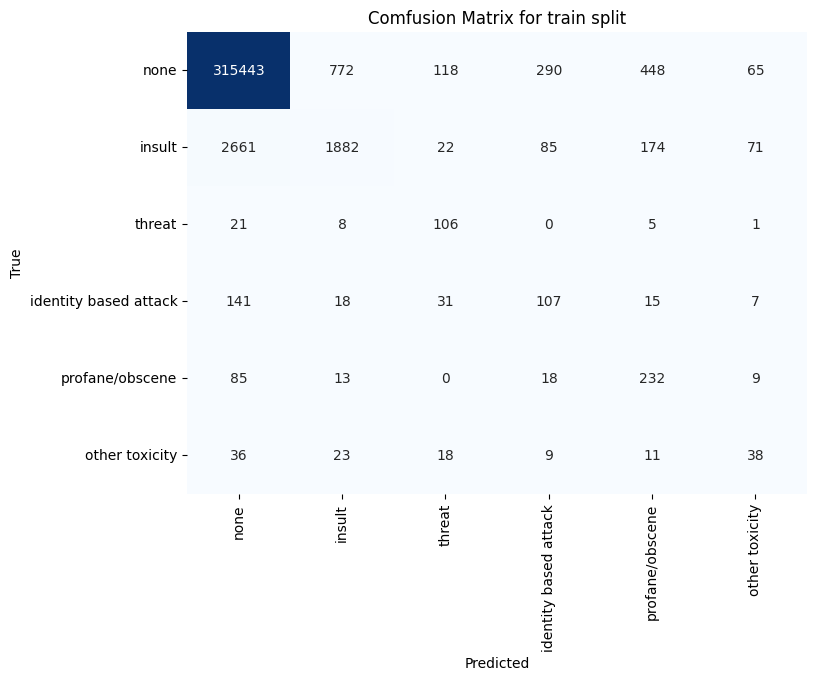

In [19]:
plot_confusion_matrix(model, dataset, 'train')

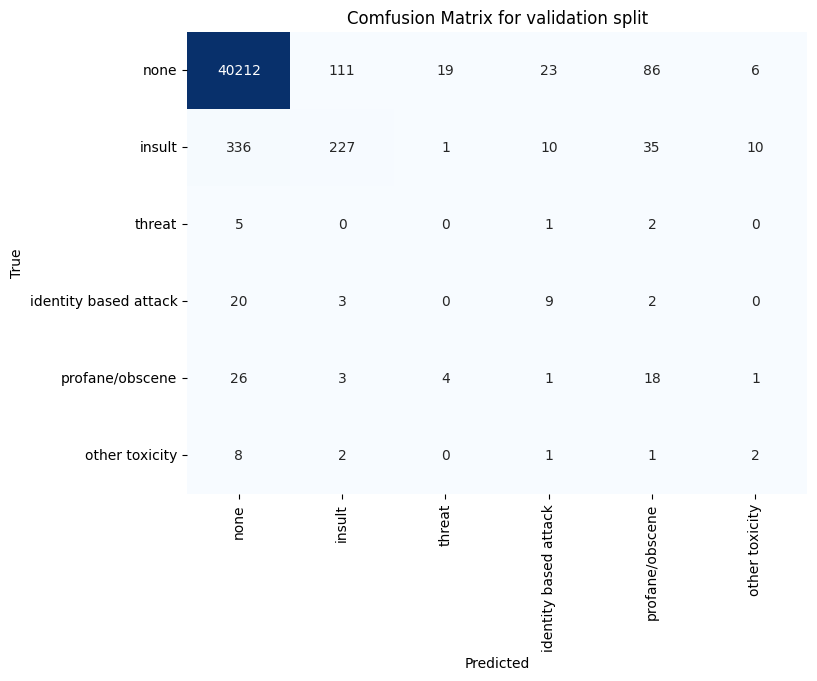

In [20]:
plot_confusion_matrix(model, dataset, 'validation')

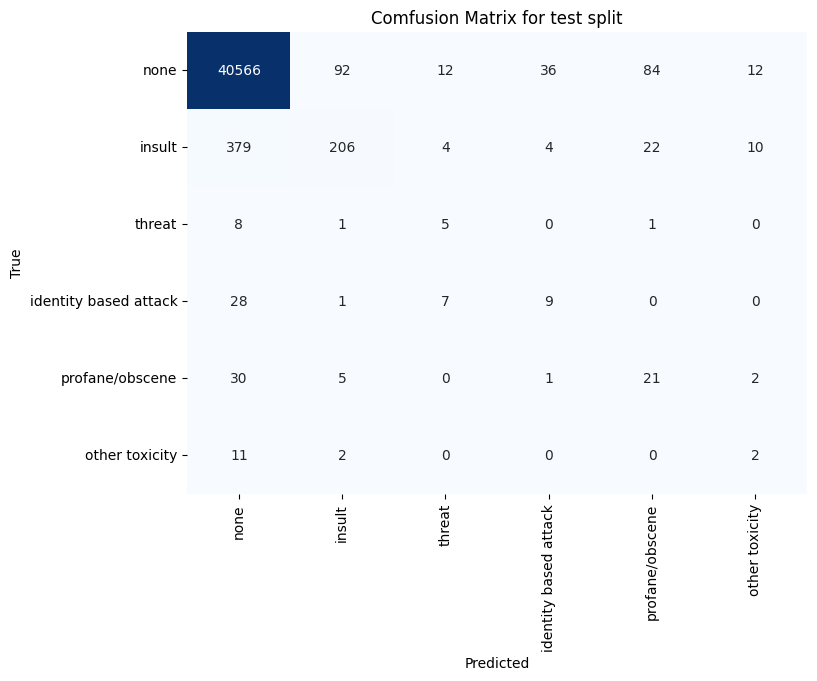

In [21]:
plot_confusion_matrix(model, dataset, 'test')

**You can play around with my model by visiting this link:**
[huggingface.co/Sinanmz/toxicity_token_classifier](https://huggingface.co/Sinanmz/toxicity_token_classifier)